Implementing RAG based on my HW 

im just tryna learn rag. This project is an implementation based off of my COGSCI-132 hw. 

RAG can be broken down into 5 actionable steps:

1. Load: We load in our data using DocumentLoaders. 
2. Split: Our data is split into chunks in order to be captured within the context window. We will use RecursiveTextSplitter to recursively split our text until the chunks are within the limt 
3. Store: The split data is then converted into embeddings. Embeddings is a way for text to be represented numerically for computers to understand. These embeddings are then stored in a vector store.
4. Retrieve: The most relevant embeddings are retrieved based on a similarity search with the query.
5. Generate: Both the query and most relevant context are then passed into the LLM to output the most accurate response.

Setup

We instantiate LangSmith for tracing, as well as OpenAI. The import getpass is used for a more secure input.

In [14]:
# our text splitters and langchain
%pip install --quiet --upgrade langchain-text-splitters langchain_community langgraph 

# our llm 
%pip install -qU "langchain[openai]"

# our vector db 
%pip install -qU langchain-chroma 

# our pdf document loader
%pip install "langchain-unstructured[local]" 
%pip install --upgrade --quiet langchain-unstructured unstructured-client unstructured "unstructured[pdf]" python-magic

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import getpass 
import os 

os.environ["LANGSMITH_TRACING"] = "True"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [5]:
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass('Enter OpenAI API Key: ')

Here we will instantiate our LLM model, vector DB and our embeddings function.

In [51]:
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma 

llm = init_chat_model("openai:gpt-5-nano") # or (model="gpt-5-nano", model_provider="openai")

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    collection_name="homework",
    embedding_function=embeddings
)

Indexing 

We are going to index our data using **Unstructured**. This will allow us to parse not only text but also images within PDF documents.

In [99]:
from langchain_unstructured import UnstructuredLoader
from unstructured.cleaners.core import clean_extra_whitespace
import json

file_path = 'data/ermentrout-and-terman-ch-1.pdf'

loader = UnstructuredLoader(
    file_path,
    post_processors=[clean_extra_whitespace]
)
docs = loader.load()

# chroma doesnt accept complex metadata like dicts or lists
# this code loops through all docs, all key value pairs inside the metadata and checks instances of dicts or lists
# it will replace the value with a stringified version of the original value.
for doc in docs:
    for key,value in doc.metadata.items():
        if isinstance(value, (dict,list)):
            doc.metadata[key] = json.dumps(value)


total_chars = "".join([doc.page_content for doc in docs])
print("Number of documents: ", len(docs))
print("Length of characteres: ", len(total_chars))

Number of documents:  796
Length of characteres:  58532


Splitting Documents

The length of characters exceeds the context window, and it would be difficult for models to find information with very long inptus.

To handle this we split the documents into chunks for embedding and vector storage to retrieve only the most relevant information. 

We will use RecursiveTextSplitter to recursively split our text until the chunks are within the context window limit.

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Initialize RecursiveCharacterTextSplitter 
# params: chunks, overlap, add_start_index 
# overlap for the context to not be cutoff 
# add_start_index makes each chunk store their orginal position in the text 
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1200,
    chunk_overlap=300,
    add_start_index=True
)

# to actually split the documents we use the split_documetns method 
all_splits = text_splitter.split_documents(docs)

print(f"split documents into {len(all_splits)}")


split documents into 797


Store

We will use a vector db to store these chunks in order to index and embed them for search during runtime. We can do this in a single line to handle both embedding and chunk storage. 

In [65]:
documents_ids = vector_store.add_documents(documents=all_splits)
print(documents_ids[:3])

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


['4494c594-41b1-4c1f-9df3-3b32f1334205', '0d400d2f-1412-4965-b439-c8d42a534009', '29f00ce0-5d54-41e9-98ea-e58190de40d2']


Retrieval and Generation

We will now create a simple application that takes a user question, retrieves the most relevant context, and inputs both the question and context to an LLM. 

In [ ]:
from langchain import hub

# pull prompt from hub. Good for maintaining prompts 
prompt = hub.pull('rlm/rag-prompt')

example_message = prompt.invoke(
    {"context": "(context goes here)", "question": "(answer goes here)"}
).to_messages() # formats prompt output 

print(example_message[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (answer goes here) 
Context: (context goes here) 
Answer:


We will now use LangGraph to tie in both retrieval and generation into a single application

We need: 

1. State (our application)
2. Nodes (the steps in our application)
3. Control Flow (the ordering of steps)

State

State is what controls the input of our application, what is transferred between steps, and also whats output. 

For simple RAG we are tracking the question, answer, and context

In [70]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

Nodes

Nodes are our steps in the application. We will have retrieval and generation 

Retrieval uses similarity search to find documents most relevant to our question, generation will take both question and context to generate the most accurate answer. 

In [72]:
def retrieve(state:State):
    retrieved_docs = vector_store.similarity_search(state['question'])
    return {"context": retrieved_docs}

def generate(state:State):
    # join docs content 
    docs_content = "".join([doc.page_content for doc in state["context"]])
    # pass question and context
    messages = prompt.invoke(
        {"question": state['question'], "context": docs_content}
    )
    # generate response 
    response = llm.invoke(messages)
    return {"answer": response}

Control Flow 

Here we compile our application into a single graph object connecting retrieval and generation into one step.

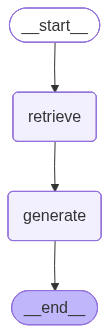

In [ ]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

# create a sequence of steps: retrieve and generate 
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
# signify the start of the graph 
graph_builder.add_edge(START, 'retrieve')
graph = graph_builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

In [100]:
result = graph.invoke({"question": "What are the Hodgkin-Huxley equations?"})

print(f"Context: {result["context"]}\n\n")
print(f"Answer: {result["answer"]}\n\n")

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Context: [Document(id='9a86b340-837d-4570-9d3e-c8baa839eb73', metadata={'element_id': '911197208cf17cc409c7ff2273ddf78d', 'start_index': 0, 'source': 'data/ermentrout-and-terman-ch-1.pdf', 'page_number': 22, 'filename': 'ermentrout-and-terman-ch-1.pdf', 'category': 'Header', 'languages': '["eng"]', 'filetype': 'application/pdf', 'coordinates': '{"points": [[269.16306294000003, 35.864399400000025], [269.16306294000003, 44.33259940000005], [385.2375271599998, 44.33259940000005], [385.2375271599998, 35.864399400000025]], "system": "PixelSpace", "layout_width": 439.0, "layout_height": 666.0}', 'file_directory': 'data', 'last_modified': '2025-09-16T12:28:07'}, page_content='1 The Hodgkin–Huxley Equations'), Document(id='64430e4c-657f-40e8-8e48-dcc52784c8e0', metadata={'element_id': 'ba194cde0dc093fbc9afb8b016df85de', 'filetype': 'application/pdf', 'category': 'Header', 'source': 'data/ermentrout-and-terman-ch-1.pdf', 'coordinates': '{"points": [[269.15882884, 35.864399400000025], [269.15882